# **Bayesian Nonparametrics in Practice**

---

## What are Bayesian nonparametric models?
Bayesian nonparametric models are models where the number of parameters grow freely with the amount of data provided; thus, instead of training several models that vary in complexity and comparing them, one is able to design a model whose complexity grows as more data are observed. The prototypical example of Bayesian nonparametrics in practice is the *Dirichlet Process Mixture Model* (DPMM), which also serves as the focus of this project. A DPMM allows for a practitioner to build a mixture model when the number of distinct clusters in the geometric structure of their data is unknown – in other words, the number of clusters is allowed to grow as more data is observed. This feature makes the DPMM highly useful towards exploratory data analysis, where few facets of the data in question are known; this presentation aims to demonstrate this fact. In particular, I will cover two formulations of the DPMM, three applications, and three distinct inference implementations. 

## The Dirichlet Process (Ferguson, 1973)
Dirichlet processes are a family of probability distributions over discrete probability distributions. Formally, the Dirichlet process (DP) is specified by some base probability distribution $G_0: \Omega \to \mathbb{R}$ and a positive, real, scaling parameter commonly denoted as $\alpha$. For any disjoint union $\Omega_1, ..., \Omega_k$ of $\Omega$, and any sample $G \sim DP(G_0, \alpha)$, we have:

$$(G(\Omega_1), ..., G(\Omega_k)) \sim \text{Dir}(\alpha G_0(\Omega_1), ..., \alpha G_0(\Omega_k))$$

While quite abstract in formulation, the Dirichlet process is very useful as a prior in various graphical models. This fact becomes easier to see in the following scheme.

## The Chinese Restaurant Process (Aldous, 1985)

Imagine a restaurant with infinite tables (indexed by the positive integers) that accepts customers one at a time. The $n$th customer chooses their seat according to the following probabilities:

*   With probability $\frac{n_t}{\alpha + n - 1}$, sit at table $t$, where $n_t$ is the number of people at table $t$
*   With probability $\frac{\alpha}{\alpha + n - 1}$, sit at an empty table

If we associate to each table $t$ a draw from a base distribution $G_0$ and then associate probability mass $n_t$ to that draw, the resulting distribution over $\Omega$ is equivalent to a draw from a Dirichlet process $DP(G_0, \alpha)$. 

Furthermore, we can easily extend this to define the generative process of a nonparametric mixture model: every table $t$ that has at least one customer seated is associated with a set of cluster parameters $\theta_t$, which were themselves drawn from some base distribution $G_0$. For each new observation, first assign that observation to a table according to the above probabilities; then, that observation is drawn from the distribution parameterized by the cluster parameters for that table. If the observation was assigned to a new table, draw a new set of cluster parameters from $G_0$, and then draw the observation from the distribution parameterized by those cluster parameters.

While this formulation of a Dirichlet process mixture model is intuitive, it is also very difficult to perform inference on in a probabilistic programming framework. This motivates an alternative formulation of DPMMs, which has empirically been shown to be more conducive to inference (e.g. Blei and Jordan, 2004).

## The Stick-Breaking Method (Sethuraman, 1994)

The generative process for the stick-breaking formulation of DPMMs proceeds as follows:

* Draw $\beta_i \sim \text{Beta}(1, \alpha)$ for $i \in \mathbb{N}$
* Draw $\theta_i \sim G_0$ for $i \in \mathbb{N}$
* Construct the mixture weights $\pi$ by taking $\pi_i(\beta_{1:\infty}) = \beta_i \prod_{j<i} (1-\beta_j)$

* For each observation $n \in \{1, ..., N\}$, draw $z_n \sim \pi(\beta_{1:\infty})$, and then draw $x_n \sim f(\theta_{z_n})$

Here, the infinite nature of the Dirichlet process mixture model can more easily be seen. Furthermore, all $\beta_i$ are independent, so it is far easier to perform inference in a probabilistic programming framework.


In [0]:
import torch
torch.manual_seed(145)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.graphics.tsaplots import plot_acf
from tqdm.notebook import tqdm

from pyro.distributions import *
import pyro
from pyro.infer.autoguide import *
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TracePredictive, EmpiricalMarginal
from torch.distributions import constraints
from pyro import poutine


# **Inference**


---


## Synthetic Mixture of Gaussians

We begin by demonstrating the capabilities of Dirichlet process mixture models on a synthetic dataset generated by a mixture of Gaussians:

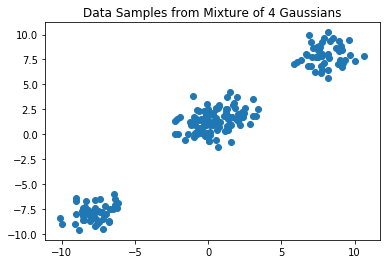

In [155]:
data = torch.cat((MultivariateNormal(-8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(8 * torch.ones(2), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([1.5, 2]), torch.eye(2)).sample([50]),
                  MultivariateNormal(torch.tensor([-0.5, 1]), torch.eye(2)).sample([50])))

plt.scatter(data[:, 0], data[:, 1])
plt.title("Data Samples from Mixture of 4 Gaussians")
plt.show()
N = data.shape[0]

In this example, the cluster parameters $\theta_i$ are two dimensional vectors describing the means of a multivariate Gaussian with identity covariance. Therefore, the Dirichlet process base distribution $G_0$ is also a multivariate Gaussian (i.e. the conjugate prior), although this choice is not as computationally useful, since we are not performing coordinate-ascent variational inference but rather black-box variational inference using Pyro. 

The variational family $q(\beta, \theta, z)$ is given by:

$$q(\beta, \theta, z) = \prod_{t=1}^{T-1} q_t(\beta_t) \prod_{t=1}^T q_t(\theta_t) \prod_{n=1}^N q_n(z_n)$$ 

Note that since we are unable to computationally model the infinite clusters posited by the model, we truncate our variational family at $T$ clusters. This does not affect our model; rather, it is a simplification made in the *inference* stage to allow tractability. The Pyro implementation is as follows:

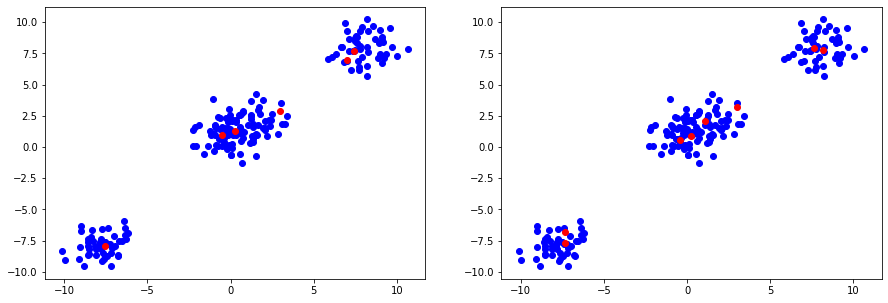

<Figure size 432x288 with 0 Axes>

In [160]:
def mix_weights(beta): 
    weights = torch.zeros(beta.shape[0] + 1)
    for t in range(beta.shape[0]):
      weights[t] = beta[t] * torch.prod(1. - beta[:t], dim=0)
    weights[beta.shape[0]] = 1. - torch.sum(weights)
    return weights

def model(data):
    with pyro.plate("beta_plate", T-1):
      beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("mu_plate", T):
      mu = pyro.sample("mu", MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(mix_weights(beta)))
      pyro.sample("obs", MultivariateNormal(mu[z], torch.eye(2)), obs=data)

def guide(data):
    kappa = pyro.param('kappa', Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
      q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
      q_mu = pyro.sample("mu", MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(phi))
    
T = 8
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)
Bayes_Centers_05, Bayes_Weights_05 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_05[:, 0], Bayes_Centers_05[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.show()
plt.tight_layout()

The plots above demonstrate the effects of the scaling hyperparameter $\alpha$. A greater $\alpha$ yields a more heavy-tailed distribution of the weights, whereas smaller $\alpha$ will place more mass on fewer clusters. In particular, the middle cluster looks like it could be generated a single Gaussian (although in fact it was generated by two distinct Gaussians), and thus the setting of $\alpha$ allows the practitioner to further encode their prior beliefs about how many clusters the data contains.

## Dirichlet Mixture Model for Long Term Solar Observations 

As mentioned earlier, the Dirichlet process mixture model truly shines when exploring a dataset whose latent geometric structure is completely unknown. To demonstrate this, I fit a DPMM on sunspot count data taken over the past 300 years (provided by the Royal Observatory of Belgium):

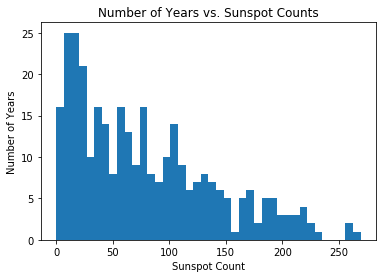

In [0]:
# # COLAB DELETE ALL
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive
# %cd My\ Drive
# %cd Colab\ Notebooks

df = pd.read_csv('sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
# df = pd.read_csv('./data/sunspot.csv', sep=';', names=['time', 'sunspot.year'], usecols=[0, 1])
data = torch.tensor(df['sunspot.year'].values, dtype=torch.float32)
N = data.shape[0]

plt.hist(df['sunspot.year'].values, bins=40)
plt.title("Number of Years vs. Sunspot Counts")
plt.xlabel("Sunspot Count")
plt.ylabel("Number of Years")
plt.show()

For this example, the cluster parameters $\theta_i$ are rate parameters since we are constructing a scale-mixture of Poisson distributions. Again, $G_0$ is chosen to be the conjugate prior, which in this case is a Gamma distribution. While this does not strictly matter for doing inference through Pyro, we will see that it makes an alternative formulation of black-box variational inference possible. Below is a Pyro implementation of the model:

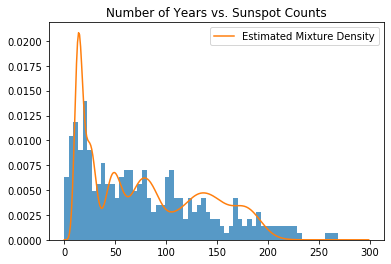

In [0]:
def model(data):
    with pyro.plate("beta_plate", T-1):
      beta = pyro.sample("beta", Beta(1, alpha))

    with pyro.plate("lambda_plate", T):
      lmbda = pyro.sample("lambda", Gamma(3, 0.05))
    
    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(mix_weights(beta)))
      pyro.sample("obs", Poisson(lmbda[z]), obs=data)

def guide(data):
    kappa = pyro.param('kappa', Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau_0 = pyro.param('tau_0', Uniform(0, 5).sample([T]), constraint=constraints.positive)
    tau_1 = pyro.param('tau_1', LogNormal(-1, 1).sample([T]), constraint=constraints.positive)
    phi = pyro.param('phi', Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
      q_beta = pyro.sample("beta", Beta(torch.ones(T-1), kappa))

    with pyro.plate("lambda_plate", T):
      q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1))

    with pyro.plate("data", N):
      z = pyro.sample("z", Categorical(phi))

T = 20
alpha = 1.1
n_iter = 1500
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

with torch.autograd.profiler.profile() as prof:
    train(n_iter)

profile_table_Pyro = prof.key_averages().table(sort_by="self_cpu_time_total")
samples = torch.arange(0, 300).type(torch.float)

tau_optimal = zip(pyro.param("tau_0").detach(), pyro.param("tau_1").detach())
kappa_optimal = pyro.param("kappa").detach()

Bayes_Rates = np.asarray([tau0 / tau1 for tau0, tau1 in tau_optimal])
Bayes_Weights = mix_weights(1. / (1. + kappa_optimal))

def mixture_of_poisson(weights, rates, samples):
  return sum( [weights[i] * np.exp(Poisson(rates[i]).log_prob(samples)) for i in range(len(weights))] )

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.title("Number of Years vs. Sunspot Counts")
plt.hist(data, bins=60, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()

### An alternative formulation of mean-field black-box variational inference

During the development of my own implementation of black-box variational inference (Ranganath, 2013), I noticed that a fairly basic algebraic property of the KL divergence could possibly be applied to simplify the optimization problem, if $q$ is chosen to be the mean-field variational family for the model.

More specifically, if $p(X, \theta_1, ..., \theta_m) = p(X | \theta_1, ..., \theta_m) p(\theta_1) ... p(\theta_m)$, and we choose $q(\theta_1, ..., \theta_m) = q_1(\theta_1) ... q_m(\theta_m)$ where $q_i(\theta_i)$ comes from the same family of distribution as $p(\theta_i)$, then we have:

$$KL (q_\phi(\theta_{1:m}) \| p(\theta_{1:m} | X) ) = \mathbb{E}_q \left[ \log \frac{q_\phi(\theta_{1:m})}{p(\theta_{1:m} | X)} \right] = \mathbb{E}_q \left[ \log q_\phi(\theta_{1:m}) \right] -  \mathbb{E}_q \left[ \log p(\theta_{1:m}, X) \right] + \log p(X)$$

$$\implies \arg \min_\phi KL (q_\phi(\theta_{1:m}) \| p(\theta_{1:m} | X) ) = \arg \min_\phi \mathbb{E}_q \left[ \log q_\phi(\theta_{1:m}) \right] -  \mathbb{E}_q \left[ \log p(\theta_{1:m}, X) \right] $$

$$ = \arg \min_\phi \mathbb{E}_q \left[ \log \frac{q_\phi(\theta_{1:m}) }{p(\theta_{1:m}, X)} \right] = \arg \min_\phi \mathbb{E}_q \left[ \log \frac{q_\phi(\theta_{1:m}) }{p(X | \theta_{1:m}) p(\theta_{1:m})} \right] $$

$$ = \arg \min_\phi \mathbb{E}_q \left[ \log \frac{q_\phi(\theta_{1}) }{p(\theta_{1})} \right] + ... + \mathbb{E}_q \left[ \log \frac{q_\phi(\theta_{m}) }{p(\theta_{m})} \right] - \mathbb{E}_q \left[ \log p(X | \theta_{1:m}) \right]$$

$$ = \arg \min_\phi \sum_{i=1}^{m} KL ( q_\phi (\theta_i) \| p(\theta_i)) - \mathbb{E}_q \left[ \log p(X | \theta_{1:m}) \right]$$

Since $q_\phi(\theta_i)$ and $p(\theta_i)$ are of the same family of distributions, we can compute their KL divergence in closed form, in linear time in the number of parameters of that type of distribution. Thus we only need to perform Monte Carlo integration over the likelihood of the data given some sampling of latent variables from the mean-field variational family.

Define:

$$\mathcal{L}(\phi) = \sum_{i=1}^{m} KL ( q_\phi (\theta_i) \| p(\theta_i)) - \mathbb{E}_q \left[ \log p(X | \theta_{1:m}) \right]$$ 
We will end up taking the gradient of the above expression with respect to $\phi$. To deal with the log-likelihood term, note that:

$$\nabla_\phi \mathbb{E}_q \left[ \log p(X | \theta_{1:m}) \right] = \nabla_\phi \int_{\theta_{1:m}} \log p(X | \theta_{1:m}) q_\phi(\theta_{1:m}) d \theta_{1:m} = \int_{\theta_{1:m}} \log p(X | \theta_{1:m})  \nabla_\phi q_\phi(\theta_{1:m}) d \theta_{1:m}$$

$$ = \sum_{n=1}^N \int \log p(x_n | \theta_{1:m}) \nabla_\phi q_\phi(\theta_{1:m}) d \theta_{1:m}$$

$$ = \sum_{n=1}^N \int  \nabla_\phi \log q(\theta_{1:m})  \log p(x_n | \theta_{1:m}) q_\phi(\theta_{1:m}) d \theta_{1:m}$$

The implementation of this procedure can be found in `manual_bbvi.py` in the repository. The results of performing inference in this manner are presented below:

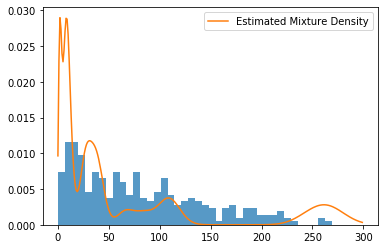

In [0]:
from manual_bbvi import bbvi

hyperparameters = {
    'alpha': 1.2,
    'lambda_0': 3.,
    'lambda_1': 0.05,
    'T': T,
    'n_iter': n_iter,
    'num_samples': 200,
    'lr': 0.005
}

with torch.autograd.profiler.profile() as prof:
    kappa, tau, phi = bbvi(data, hyperparameters) # These are the variational parameters for the Beta, Gamma, and Categorical distributions

profile_table_Manual = prof.key_averages().table(sort_by="self_cpu_time_total")
Bayes_Rates = [tau_i[0] / tau_i[1] for tau_i in tau.detach()]
Bayes_Weights = torch.mean(phi, dim=0)

likelihood = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)
plt.hist(data, bins=40, density=True, lw=0, alpha=0.75);
plt.plot(samples, likelihood, label="Estimated Mixture Density")
plt.legend()
plt.show()

### Torch Profiling (for Inference Comparison)

Below are two tables generated using PyTorch's built-in autograd Profiler - the first depicts the computational time taken by Pyro's BBVI implementation on the DPMM, and the second depicts the computational time taken by my manual BBVI implementation with the 'mean-field trick'. On Google Colab, using the long-term solar observations dataset and 2000 iterations of BBVI (with all other hyperparameters equal), the average CPU time for Pyro BBVI was 19.2 seconds, whereas with my trick, the average CPU time was 12.6 seconds. Empirically, this would suggest that using this mean-field trick can yield significant computational speed boosts, if the mean-field variational family is reasonable for the model at hand.

In [0]:
print ("COMPUTATIONAL TIME (PYRO BBVI)")
print (profile_table_Pyro)

print ("\n\n")

print ("COMPUTATIONAL TIME (MANUAL BBVI)")
print (profile_table_Manual)

COMPUTATIONAL TIME (PYRO BBVI)
-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
Name                                 Self CPU total %  Self CPU total   CPU total %      CPU total        CPU time avg     CUDA total %     CUDA total       CUDA time avg    Number of Calls  
-----------------------------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  
_sample_dirichlet                    18.09%           3.469s           18.09%           3.469s           867.339us        NaN              0.000us          0.000us          4000             
mul                                  10.91%           2.091s           10.91%           2.091s           6.535us          NaN              0.000us          0.000us          320000           
sum          

### ELBO Behavior

Below are plots of the behavior of the loss function (negative Trace_ELBO) over the SVI iterations during inference using Pyro, as well as a plot of the autocorrelations of the ELBO 'time series' versus iteration number. We can see that around 500 iterations, the loss stops decreasing significantly, so we can assume it takes around 500 iterations to achieve convergence. The autocorrelation plot reaches an autocorrelation very close to 0 around a lag of 400, further corroborating this hypothesis.

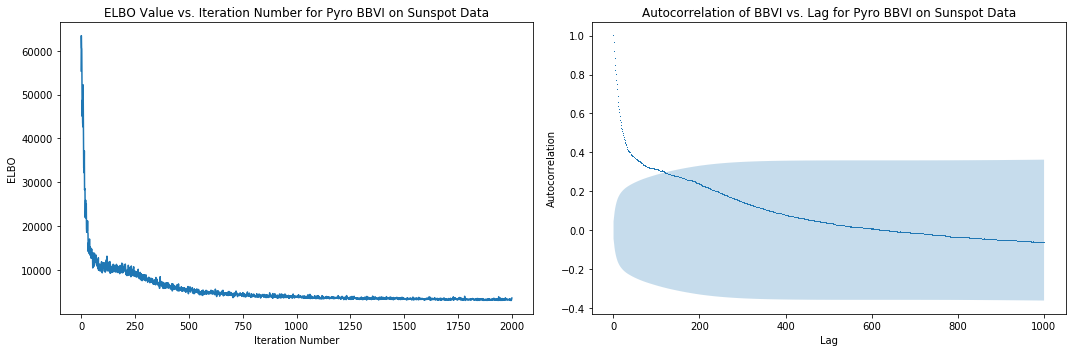

In [0]:
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI on Sunspot Data")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)

autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
plot_acf(np.asarray(losses), ax=autocorr_ax, lags = 750, use_vlines=False, marker=',')
autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI on Sunspot Data")
autocorr_ax.set_xlabel("Lag")
autocorr_ax.set_ylabel("Autocorrelation")
elbo_plot.tight_layout()
elbo_plot.show()


## Dirichlet Mixture Model on MNIST

What if we were to approach the handwritten digit recognition problem, without knowing how many numbers there are in the modern numeral system? Such an exploration again motivates a Dirichlet process mixture; I implemented MAP inference on a Dirichlet process multivariate Gaussian mixture to compute cluster parameters and digit assignments for the 8x8 MNIST dataset. 

I chose to perform MAP inference for two reasons - one, I wanted to compare and contrast several inference methods for Dirichlet process mixtures, and two, variational inference converged to poor approximations of the posterior. I was able to derive coordinate-ascent MAP updates in closed form (using Blei and Jordan, 2004, Bishop, 2006, and sklearn documentation), which greatly enhanced both estimations and computational speed.

In [0]:
from sklearn import datasets
from dpmm_map import dpmm 

digits = datasets.load_digits()
data = digits['data']
labels = digits['target']
mnist_tsne = np.load("mnist_tsne.npz")['arr_0']
N, D = data.shape
n_iter = 500

hyperparameters = {
    'dof': D,
    'alpha': 0.5,
    'gamma': 1.8,
    'T': 16,
    'truncation': 0.02,
    'n_iter': n_iter,
    'mean_prec': 1.
}

dpmm_labels, losses = dpmm(data, hyperparameters)

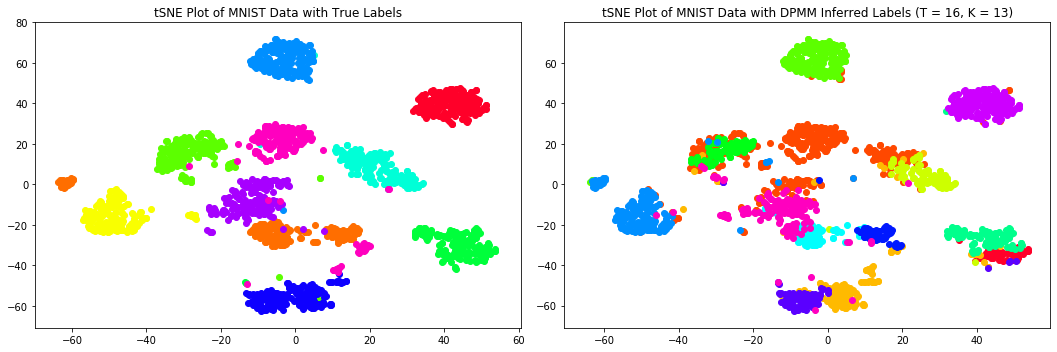

In [0]:
def generate_color_categories(categories):
    ncol = len(categories)
    cmap = cm.get_cmap(name='gist_rainbow')
    colors = cmap(np.linspace(0, 1, ncol))
    color_map = {}
    for i, key in enumerate(categories):
        color_map[key] = colors[i]
    return color_map

def plot_clusters(data, labels, color, ax):
    for idx, label in enumerate(np.unique(labels)):
      ax.scatter(data[labels==label, 0], data[labels==label, 1], color=color[label])

true_colors = generate_color_categories(np.unique(labels))
dpmm_colors = generate_color_categories(np.unique(dpmm_labels))

mnist_plot = plt.figure(figsize=(15, 5))
true_ax = mnist_plot.add_subplot(1, 2, 1)
true_ax.set_title("tSNE Plot of MNIST Data with True Labels")
plot_clusters(mnist_tsne, labels, true_colors, true_ax)

dpmm_ax = mnist_plot.add_subplot(1, 2, 2)
dpmm_ax.set_title("tSNE Plot of MNIST Data with DPMM Inferred Labels (T = 16, K = {})".format(len(np.unique(dpmm_labels))))
plot_clusters(mnist_tsne, dpmm_labels, dpmm_colors, dpmm_ax)

mnist_plot.tight_layout()
mnist_plot.show()

The plot above on the left is a plot of the tSNE embedding of the 8x8 MNIST data, where colors represent the true different digit labels. The plot on the right is the same tSNE embedding, where colors were assigned by the Dirichlet process mixture model. In particular, note that we set a max truncation of $T = 16$, and the model fit $13$ clusters to the data. While this is still $3$ clusters greater than we know truly exist in the dataset, it nevertheless demonstrates the potential efficacy of DPMMs in unsupervised exploratory data analysis.

Below, we plot the value of the loss function at each iteration over the course of training. We can hypothesize that convergence occurs very quickly, at less than 100 iterations into training. This is further corroborated by the autocorrelation plot, which shows that autocorrelation in the loss series is almost 0 at a lag of 30.

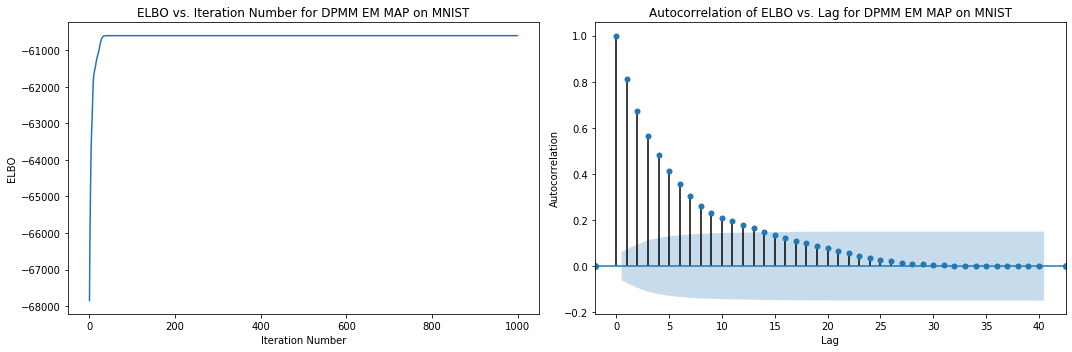

In [0]:
mnist_elbo_plot = plt.figure(figsize=(15, 5))

mnist_elbo_ax = mnist_elbo_plot.add_subplot(1, 2, 1)
mnist_elbo_ax.set_title("Loss vs. Iteration Number for DPMM EM MAP on MNIST")
mnist_elbo_ax.set_ylabel("Loss")
mnist_elbo_ax.set_xlabel("Iteration Number")
mnist_elbo_ax.plot(np.arange(n_iter), losses)

mnist_autocorr_ax = mnist_elbo_plot.add_subplot(1, 2, 2)
plot_acf(np.asarray(losses), ax=mnist_autocorr_ax, lags = 40, marker='o')
mnist_autocorr_ax.set_title("Autocorrelation of Loss vs. Lag for DPMM EM MAP on MNIST")
mnist_autocorr_ax.set_xlabel("Lag")
mnist_autocorr_ax.set_ylabel("Autocorrelation")
mnist_elbo_plot.tight_layout()
mnist_elbo_plot.show()

# **Criticism**

---



## Long-Term Sunspot Model

Since we computed the approximate posterior of the DPMM that was fit to the long-term sunspot data, we can utilize the intrinsic metrics discussed in class, such as the mean log predictive, posterior dispersion indices, and posterior predictive checks. Since the posterior predictive distribution for a Dirichlet process mixture model is itself a scale-mixture distribution that has an analytic approximation (Blei and Jordan, 2004), this makes it particularly amenable to the aforementioned metrics:

$$p(x_{new} | X_{1:N}, \alpha, G_0) \approx \sum_{t=1}^T \mathbb{E}_q [\pi_t(\beta)] \ \mathbb{E}_q \left[p(x_{new} | \theta_t)\right].$$

We compute these below on a holdout subset of the data, after re-training the model on a training subset. 


Mean Log Predictive:  -0.11482847
Mean Predictive:  0.89151907


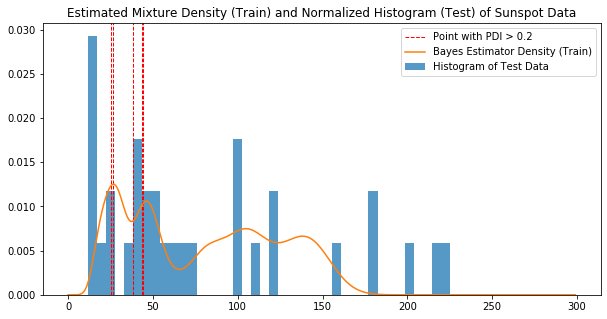

In [153]:
from sklearn.model_selection import train_test_split
from posterior_predictive import log_posterior_predictive_eval, sq_log_posterior_predictive_eval, posterior_predictive_sample

data, data_test = train_test_split(df['sunspot.year'].values, test_size=0.1)
data = torch.tensor(data, dtype=torch.float)
data_test = torch.tensor(data_test, dtype=torch.float)
N = data.shape[0]
T = 20

svi = SVI(model, guide, optim, loss=Trace_ELBO())
train(500)

kappa_final = pyro.param("kappa").detach()
tau_0_final = pyro.param("tau_0").detach()
tau_1_final = pyro.param("tau_1").detach()
S = 100
N_test = data_test.shape[0]

# Mean Log Predictive
log_predictive = torch.zeros(N_test)
for idx in range(N_test):
    log_predictive[idx] += log_posterior_predictive_evaluate(data_test[idx], kappa_final, tau_0_final, tau_1_final, S)
mean_log_predictive = torch.mean(log_predictive)
print ("Mean Log Predictive: ", mean_log_predictive.numpy())
print ("Mean Predictive: ", np.exp(mean_log_predictive.numpy()))

# Posterior Dispersion Indices
pdi = []
for d in data_test:
    pdi_d = (sq_log_posterior_predictive_eval(d, kappa_final, tau_0_final, tau_1_final, S) \
              - log_posterior_predictive_eval(d, kappa_final, tau_0_final, tau_1_final, S) ** 2) \
                  / log_posterior_predictive_eval(d, kappa_final, tau_0_final, tau_1_final, S)
    pdi.append(pdi_d)
pdi = np.asarray(pdi)

Bayes_Rates = np.asarray([tau0 / tau1 for tau0, tau1 in zip(tau_0_final, tau_1_final)])
Bayes_Weights = mix_weights(1. / (1. + kappa_final))

samples = torch.arange(0, 300).type(torch.float)
likelihood_predictive = mixture_of_poisson(Bayes_Weights, Bayes_Rates, samples)

plt.figure(figsize=(10, 5))
plt.hist(data_test, bins=40, density=True, lw=0, alpha=0.75, label="Histogram of Test Data");
for pt in data_test[pdi > 0.2]:
  if pt == data_test[pdi > 0.2][0]:
    plt.axvline(pt, color='r', linestyle='dashed', linewidth=1, label="Point with PDI > 0.2") 
  else: 
    plt.axvline(pt, color='r', linestyle='dashed', linewidth=1)
plt.plot(samples, likelihood_predictive, label="Bayes Estimator Density (Train)") 
plt.title("Estimated Mixture Density (Train) and Normalized Histogram (Test) of Sunspot Data")
plt.legend()
plt.show()

The mean log predictive on the holdout set is $0.89$, which indicates that our learned mixture does a decent job at generalizing to new data. However, there are several points with posterior dispersion indices greater than $0.2$, indicating that there is a subset of the true population distribution that our mixture model is bad at modelling. 

Examining the above plot, which displays the learned density from the training set, the histogram of the test data, and dashed lines at points with high posterior dispersion indices, we can see that the modeling is doing a poor job of explaining points that are near the left tail of the distribution. Adjusting the hyperparameters on our prior base distribution $G_0$ so that it has a heavier left tail could possibly remedy this fact.

To further analyze how effectively our model can explain our data, we perform posterior predictive checks on the max, min, median, and mean statistics:

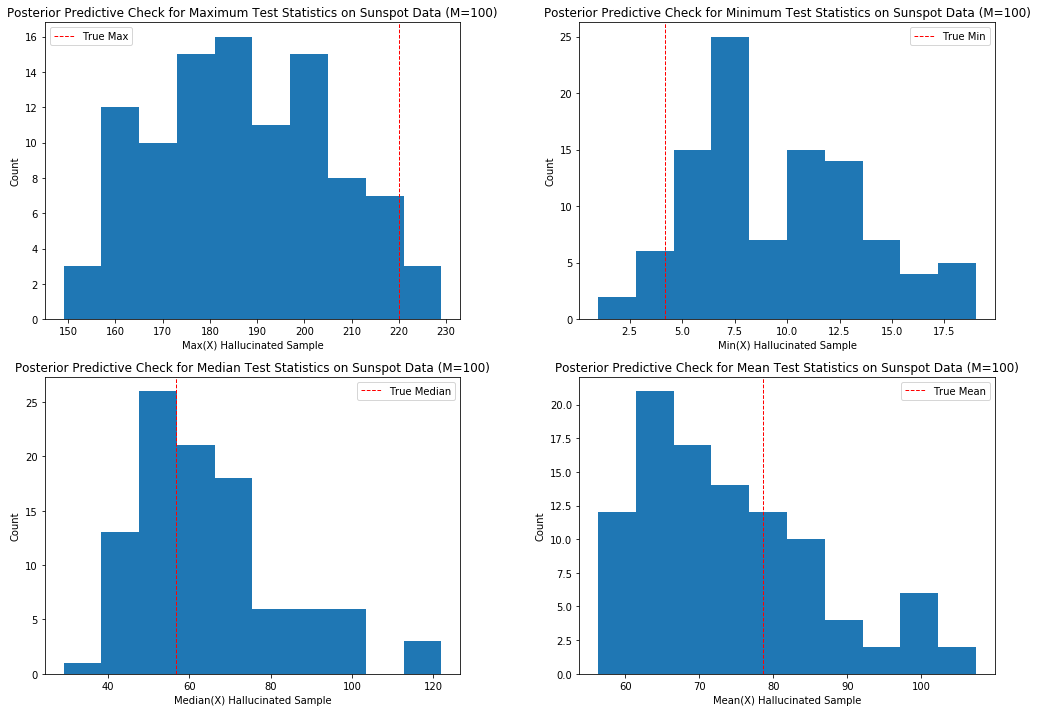

In [146]:
# PPC
ppc_samples = posterior_predictive_sample(kappa_final, tau_0_final, tau_1_final, S, N)
test_stat_max = torch.zeros(S)
test_stat_min = torch.zeros(S)
test_stat_med = torch.zeros(S)
test_stat_mean = torch.zeros(S)
for s in range(S):
    test_stat_max[s] = torch.max(ppc_samples[s, :])
    test_stat_min[s] = torch.min(ppc_samples[s, :])
    test_stat_med[s] = torch.median(ppc_samples[s, :])
    test_stat_mean[s] = torch.mean(ppc_samples[s, :])

ppc_stats = plt.figure(figsize=(15, 10))

ppc_ax = ppc_stats.add_subplot(2, 2, 1)
ppc_ax.set_title("Posterior Predictive Check for Maximum Test Statistics on Sunspot Data (M=100)")
ppc_ax.set_xlabel("Max(X) Hallucinated Sample")
ppc_ax.set_ylabel("Count")
ppc_ax.axvline(torch.max(data_test), color='r', linestyle='dashed', linewidth=1, label="True Max") 
ppc_ax.legend()
ppc_ax.hist(test_stat_max, bins=10)

ppc_ax = ppc_stats.add_subplot(2, 2, 2)
ppc_ax.set_title("Posterior Predictive Check for Minimum Test Statistics on Sunspot Data (M=100)")
ppc_ax.set_xlabel("Min(X) Hallucinated Sample")
ppc_ax.set_ylabel("Count")
ppc_ax.axvline(torch.min(data_test), color='r', linestyle='dashed', linewidth=1, label="True Min") 
ppc_ax.legend()
ppc_ax.hist(test_stat_min, bins=10)

ppc_ax = ppc_stats.add_subplot(2, 2, 3)
ppc_ax.set_title("Posterior Predictive Check for Median Test Statistics on Sunspot Data (M=100)")
ppc_ax.set_xlabel("Median(X) Hallucinated Sample")
ppc_ax.set_ylabel("Count")
ppc_ax.axvline(torch.median(data_test), color='r', linestyle='dashed', linewidth=1, label="True Median") 
ppc_ax.legend()
ppc_ax.hist(test_stat_med, bins=10)

ppc_ax = ppc_stats.add_subplot(2, 2, 4)
ppc_ax.set_title("Posterior Predictive Check for Mean Test Statistics on Sunspot Data (M=100)")
ppc_ax.set_xlabel("Mean(X) Hallucinated Sample")
ppc_ax.set_ylabel("Count")
ppc_ax.axvline(torch.mean(data_test), color='r', linestyle='dashed', linewidth=1, label="True Mean") 
ppc_ax.legend()
ppc_ax.hist(test_stat_mean, bins=10)

ppc_stats.tight_layout()
ppc_stats.show()

These plots show that our model is good at capturing the median and mean statistics of the empirical distribution, but consistently overestimates the minimum and underestimates the maximum. If we care about having a strong estimate of the maximum or the minimum, we could again adjust the hyperparameters of the base distribution $G_0$ to give it heavier tails.

## MNIST Model

Since we inferred the latent variables of the MNIST model with a point-based MAP estimate, we cannot compute the typical probabilistic metrics that are intrinsic to the model, as we did above. However, since we know the true number of clusters that should exist in the dataset (10), we can use the "number of clusters discovered" during model fitting as an intrinsic metric. Additionally, we can utilize extrinsic metrics that are commonly used in clustering. These can be used in order to assist in the setting of the hyperparameters. Let's estimate what the optimal value of $\alpha$, the scaling hyperparameter, should be, based on several different clustering metrics:

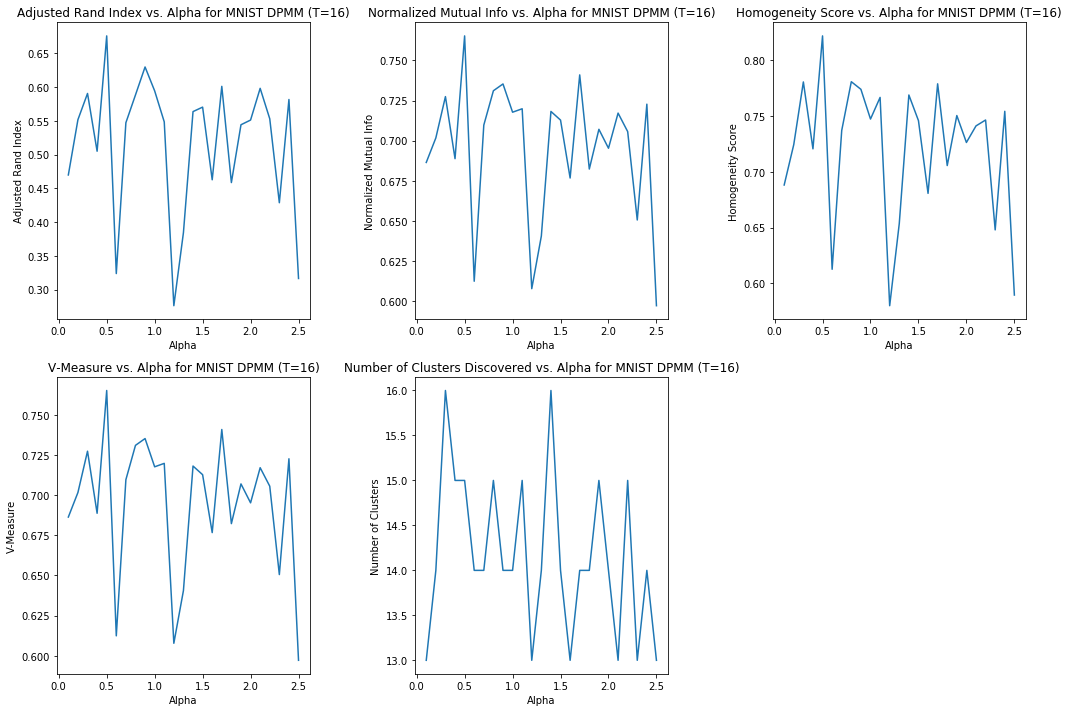

In [150]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, v_measure_score

alphas = np.linspace(0.1, 2.5, num=25)
data = digits['data']
scores = []
n_clusters = []
for a in alphas:
  hyperparameters['n_iter'] = 100 #we don't need 1000 iterations as we have seen that MAP converges after 100 or so
  hyperparameters['alpha'] = a
  dpmm_labels, _ = dpmm(data, hyperparameters)
  scores.append([
    adjusted_rand_score(labels, dpmm_labels),
    normalized_mutual_info_score(labels, dpmm_labels, average_method='arithmetic'),
    homogeneity_score(labels, dpmm_labels),
    v_measure_score(labels, dpmm_labels)                 
  ])
  n_clusters.append(len(np.unique(dpmm_labels)))

scores = np.asarray(scores)
mnist_scores = plt.figure(figsize=(15, 10))

ari_ax = mnist_scores.add_subplot(2, 3, 1)
ari_ax.set_title("Adjusted Rand Index vs. Alpha for MNIST DPMM (T=16)")
ari_ax.set_xlabel("Alpha")
ari_ax.set_ylabel("Adjusted Rand Index")
ari_ax.plot(alphas, scores[:, 0])

ari_ax = mnist_scores.add_subplot(2, 3, 2)
ari_ax.set_title("Normalized Mutual Info vs. Alpha for MNIST DPMM (T=16)")
ari_ax.set_xlabel("Alpha")
ari_ax.set_ylabel("Normalized Mutual Info")
ari_ax.plot(alphas, scores[:, 1])

ari_ax = mnist_scores.add_subplot(2, 3, 3)
ari_ax.set_title("Homogeneity Score vs. Alpha for MNIST DPMM (T=16)")
ari_ax.set_xlabel("Alpha")
ari_ax.set_ylabel("Homogeneity Score")
ari_ax.plot(alphas, scores[:, 2])

ari_ax = mnist_scores.add_subplot(2, 3, 4)
ari_ax.set_title("V-Measure vs. Alpha for MNIST DPMM (T=16)")
ari_ax.set_xlabel("Alpha")
ari_ax.set_ylabel("V-Measure")
ari_ax.plot(alphas, scores[:, 3])

ari_ax = mnist_scores.add_subplot(2, 3, 5)
ari_ax.set_title("Number of Clusters Discovered vs. Alpha for MNIST DPMM (T=16)")
ari_ax.set_xlabel("Alpha")
ari_ax.set_ylabel("Number of Clusters")
ari_ax.plot(alphas, n_clusters)

mnist_scores.tight_layout()
mnist_scores.show()

We can see that the relationship between clustering performance and alpha is highly nonlinear. Given the results from the extrinsic clustering metrics, we would be inclined to select an alpha of $1.6$. This is corroborated by the fact that at $\alpha = 1.6$, we discover $12$ clusters, which is the closest to $10$, the true number of clusters.

Further testing would involve doing a grid-search over all of the hyperparameters that we can set in the model to find the optimal combination.

# References



1.   Ferguson, Thomas. *A Bayesian Analysis of Some Nonparametric Problems*. The Annals of Statistics, Vol. 1, No. 2 (1973). 
2.   Aldous, D. *Exchangeability and Related Topics*. Ecole diete de Probabilities Saint Flour (1985).
3.   Sethuraman, J. *A Constructive Definition of Dirichlet Priors*. Statistica, Sinica, 4:639-650 (1994).
4.   Blei, David and Jordan, Michael. *Variational Inference for Dirichlet Process Mixtures*. Bayesian Analysis, Vol. 1, No. 1 (2004).
5.   Pedregosa, et al. *Scikit-Learn: Machine Learning in Python*. JMLR 12, pp. 2825-2830 (2011).
6.   Bishop, Christopher. *Pattern Recogition and Machine Learning*. Springer Ltd (2006).
7.   *Sunspot Index and Long-Term Solar Observations*. WDC-SILSO, Royal Observatory of Belgium, Brussels (2018).


